# Likelihood of Vector Orthogonality in High-Dimensional Spaces

>  Depends on whether you're using unit vectors or not.

- toc: false 
- badges: true
- comments: true
- author: Scott H. Hawley
- image: images/multidim_dp_summary.png

One sometimes sees claims like ["within high dimensional spaces, if you choose random vectors, they tend to be orthogonal to each other,"](https://towardsdatascience.com/loss-landscapes-and-the-blessing-of-dimensionality-46685e28e6a4) but is this true?

The answer **depends on whether you're talking about unit vectors or not**.  

Let's do some direct computation. We'll vary the number of dimensions and compute a bunch of dot products between random vectors, and then plot histograms of these dot product values.  The sharper the distribution is around the value of zero, the more likely it is for vectors to be orthogonal. 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

np.random.seed(42)

n = 20000  # number of random pairs of vectors to try
dims = [2,3,5,10,100,1000]  # different dimensionalities to try
results = {}
test_num = 0

## Uniform distribution, Non-Unit Vectors

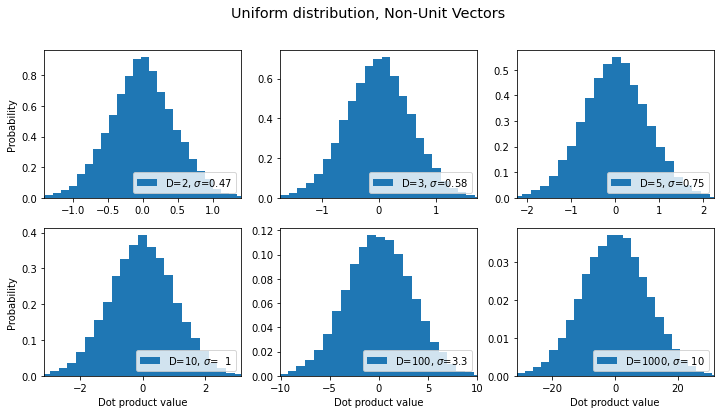

In [2]:
test_num += 1
fig, a = plt.subplots(2,3, figsize=(12,6))
results[test_num] = {'label':"Uniform distribution, Non-Unit Vectors", 'sds':[]}
fig.suptitle(results[test_num]['label'], fontsize="x-large")
a = a.ravel()
for i,ax in enumerate(a):
    dim = dims[i]
    a = 2*np.random.rand(n,dim)-1
    b = 2*np.random.rand(n,dim)-1

    dots = (a*b).sum(axis=-1)

    std = np.std(dots,axis=0)
    ax.hist(dots, density=True, bins=30, label=f'D={dim}, $\sigma$={std:3.2g}')  
    results[test_num]['sds'].append(std)
    ax.set_xlim(-3*std,3*std)
    ax.legend(loc=4)
    if i%3==0: ax.set_ylabel('Probability')
    if i>2: ax.set_xlabel('Dot product value')

From the above graph, we see that as the dimensionality D increases, it's still the case that the most common dot product is zero, but the probability distribution becomes wider & wider, i.e. the chances that a pair of random vectors are *not* orthogonal becomes increasingly *more* likely as D increases. 

## Uniform distribution, Unit vectors

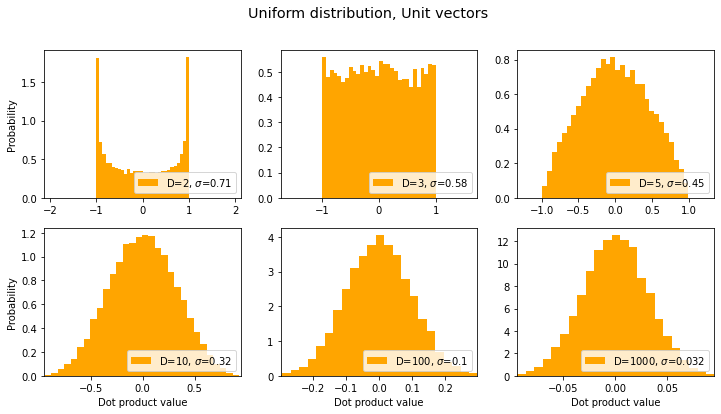

In [3]:
test_num += 1
fig, a = plt.subplots(2,3, figsize=(12,6))
results[test_num] = {'label':"Uniform distribution, Unit vectors", 'sds':[]}
fig.suptitle(results[test_num]['label'], fontsize="x-large")

def norm_rows(arr):
    mags = np.sqrt( (arr*arr).sum(axis=-1) )  # vector magnitudes
    magstiled = np.tile(mags[:,np.newaxis],(1,arr.shape[-1])) # broadcasting to make the multiplication work out
    return arr/magstiled

a = a.ravel()
for i,ax in enumerate(a):
    dim = dims[i]
    a = 2*np.random.rand(n,dim)-1
    b = 2*np.random.rand(n,dim)-1
    a, b = norm_rows(a), norm_rows(b)
    
    dots = (a*b).sum(axis=-1)
    std = np.std(dots,axis=0)
    ax.hist(dots, density=True, bins=30, label=f'D={dim}, $\sigma$={std:3.2g}',color='orange')  # density=False would make counts)
    results[test_num]['sds'].append(std)
    ax.set_xlim(-3*std,3*std)
    ax.legend(loc=4)
    if i%3==0: ax.set_ylabel('Probability')
    if i>2: ax.set_xlabel('Dot product value')

Interesting that for D=2, the vectors are more likely to be parallel or antiparallel than orthogonal, but that changes as D increases.

In the above graphs we see the opposite trend from the previous non-unit-vector case: the distribution gets narrower as D increases, meaning that a given pair of random *unit* vectors are more likely to be orthogonal as D increases.

What if we draw from a normal distribution of components instead of a uniform one?

## Normal Distribution, Non-Unit Vectors

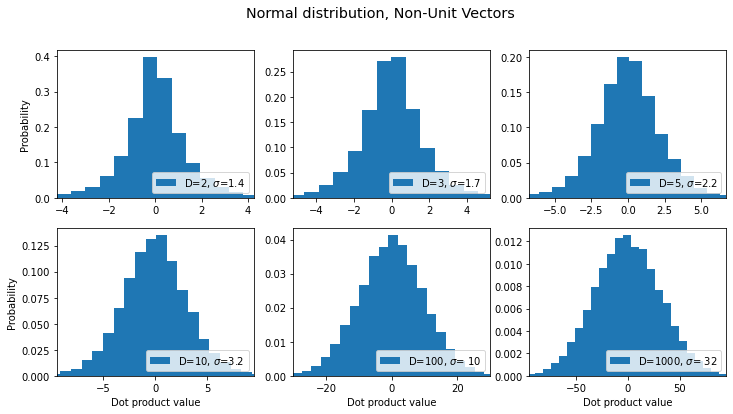

In [4]:
test_num += 1
fig, a = plt.subplots(2,3, figsize=(12,6))
results[test_num] = {'label':"Normal distribution, Non-Unit Vectors", 'sds':[]}
fig.suptitle(results[test_num]['label'], fontsize="x-large")

a = a.ravel()
for i,ax in enumerate(a):
    dim = dims[i]
    a = np.random.normal(size=(n,dim))
    b = np.random.normal(size=(n,dim))
    dots = (a*b).sum(axis=-1)
    std = np.std(dots,axis=0)
    ax.hist(dots, density=True, bins=30, label=f'D={dim}, $\sigma$={std:3.2g}')  # density=False would make counts
    results[test_num]['sds'].append(std)
    ax.set_xlim(-3*std,3*std)
    ax.legend(loc=4)
    if i%3==0: ax.set_ylabel('Probability')
    if i>2: ax.set_xlabel('Dot product value')

OK, same trend as before: the distribution gets wider as dimensionality increases. What about for unit vectors? 

## Normal distribution, Unit Vectors 

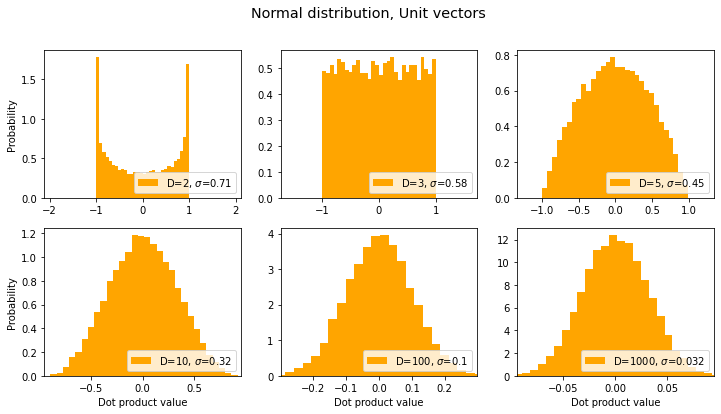

In [5]:
test_num += 1
fig, a = plt.subplots(2,3, figsize=(12,6))
results[test_num] = {'label':"Normal distribution, Unit vectors", 'sds':[]}
fig.suptitle(results[test_num]['label'], fontsize="x-large")

a = a.ravel()
for i,ax in enumerate(a):
    dim = dims[i]
    a = np.random.normal(size=(n,dim))
    b = np.random.normal(size=(n,dim))
    a, b = norm_rows(a), norm_rows(b)
    
    dots = (a*b).sum(axis=-1)
    std = np.std(dots,axis=0)
    ax.hist(dots, density=True, bins=30, label=f'D={dim}, $\sigma$={std:3.2g}', color='orange')  # density=False would make counts
    results[test_num]['sds'].append(std)
    ax.set_xlim(-3*std,3*std)
    ax.legend(loc=4)
    if i%3==0: ax.set_ylabel('Probability')
    if i>2: ax.set_xlabel('Dot product value')

Looks like the normal distribution case is the same -- wow, *exactly* the same -- as the uniform distribution only more extreme: for unit vectors, the distribution gets narrower (around 0) as the dimension increases. 

**Note:** If the vectors have only positive components (e.g. what you get from softmax) then you will *never* have orthognogonal vectors (because they all exist in the "positive subspace").

## Summary 

In all cases, the mode of the distribution is still at zero dot product.  So we can say with confidence that vectors are most likely to be (near-)orthogonal regardless of the dimensionality. However we see that although for unit vectors the distribution of dot product values gets sharper (around zero) as the number of dimensions increases, for non-unit vectors it gets *flatter*, i.e. betting on orthogonality becomes increasinly less of a safe bet as you go to higher dimensions. 

The following graph summarizes our results, in terms of the standard deviation of the distribution of dot product values:

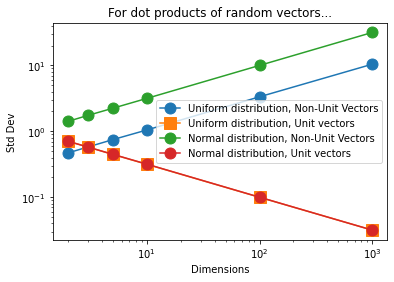

In [6]:
fig, ax = plt.subplots()
for key, val in enumerate(results):
    if val==2:  # make it so we can see the plot behind the other plot
        marker, markersize = 's-', 12
    else:
        marker, markersize = 'o-', 11
    ax.loglog(dims, results[val]['sds'], marker, markersize=markersize, label=results[val]['label'])
plt.legend()
plt.xlabel('Dimensions')
plt.ylabel('Std Dev')
plt.title("For dot products of random vectors...")
plt.show()

(where the orange line and the red line are right on top of each other) 

Thus we see that the dot products of unit vectors are more likely to be zero as the dimensionality increases, whereas for other vectors it goes the other way. 

**Also: can I just say that** I really like the scaling laws apparent in that last plot.